In [58]:
from getpass import getpass
GOOGLE_API_KEY = getpass()
LANGCHAIN_API_KEY= getpass()

 ········
 ········


In [3]:
!pip install langchain-community tqdm langchain-google-genai ipywidgets jq langchain-text-splitters lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.9/748.9 kB 17.0 MB/s eta 0:00:00


In [65]:
import os
os.environ["LANGSMITH_PROJECT"]="pr-drab-document-66"
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = LANGCHAIN_API_KEY

In [15]:
with open("books.json", "r") as file:
    content = file.read()

import json
obj = json.loads(content)
print(len(obj))

1


In [29]:
def convert_to_text_repr(json)->str:
    return f"Title of the book is {json['title']}. The book is about {json['description']} and it is written by {json['author']}."

for i,a in enumerate(obj['books']):
    obj['books'][i]['full_desc'] = convert_to_text_repr(a) 
print(obj['books'][0])

with open("books.json", "w") as file:
    file.write(json.dumps(obj))

{'book_id': 'the-call-of-the-wild', 'author': 'Jack London', 'title': 'The Call of the Wild', 'description': 'Buck, a domesticated dog, is stolen from his home and sold into service as a sled dog in the Klondike.', 'full_desc': 'Title of the book is The Call of the Wild. The book is about Buck, a domesticated dog, is stolen from his home and sold into service as a sled dog in the Klondike. and it is written by Jack London.'}


In [30]:
from langchain_community.document_loaders import TextLoader

# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:
    metadata["title"] = record["title"]
    metadata["author"] = record["author"]
    metadata["id"] = record["book_id"]
    metadata["description"] = record["description"]
    return metadata

loader = JSONLoader(
    file_path="./books.json",
    jq_schema=".books[]",
    text_content=True,
    content_key='.full_desc',
    json_lines=True,
    is_content_key_jq_parsable=True,
    metadata_func=metadata_func
)
docs = loader.load()
docs[0]

Document(metadata={'source': '/home/noobscience/Projects/rag_learn/library_system/books.json', 'seq_num': 1, 'title': 'The Call of the Wild', 'author': 'Jack London', 'id': 'the-call-of-the-wild', 'description': 'Buck, a domesticated dog, is stolen from his home and sold into service as a sled dog in the Klondike.'}, page_content='Title of the book is The Call of the Wild. The book is about Buck, a domesticated dog, is stolen from his home and sold into service as a sled dog in the Klondike. and it is written by Jack London.')

In [31]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GOOGLE_API_KEY)

In [32]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [35]:
print(len(all_splits))

40


In [34]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(documents=all_splits)

['4029b357-febc-496d-b80f-ee892c393daa',
 '2ec25b06-1860-4268-ae96-d95575c9b416',
 'd7daa0cb-570c-465b-8ae1-00af8a908ba2',
 '2bbcfcc1-c9e6-4dbd-89f4-a8f10c4f3cdb',
 '040a6c39-2b18-4a33-9148-c618b4457988',
 '2c971cb3-d455-4759-9dd5-027b5419b387',
 'b530c89d-01d2-4861-bd51-9ee85276f780',
 '9638b668-0dd5-45d0-a99e-546049fff9f0',
 'e5c6ea22-96f9-4aeb-b716-717929408a77',
 'd357a81b-70aa-4082-bd09-24803ed16631',
 'fb1cf9f5-965c-4669-954b-51008ba6794b',
 'cd2e3f56-c6a9-40f9-a130-e98246f35d5f',
 'cd24efb7-5ba2-4127-af21-eb615cd9f95d',
 'bfd05bab-50ca-43a8-8dbb-4871c6fc33c5',
 'e9f2171b-ef54-400d-9723-8d3f1247dc01',
 '93bc3a89-844f-4b2f-9402-f1eada1ba30e',
 '08b58cc4-552f-474d-9e99-6ac20b560258',
 '830cbe02-e79d-4835-8fd7-9460900590ec',
 'a5d94d61-c640-422d-bd5a-6b597c56f61e',
 '9653ee95-abe5-470f-acae-20c220e85381',
 '717d011c-7309-4ebb-9eb2-ba5dcbcb0a3c',
 '61783177-7ce0-4fa2-8254-bc99f5853b14',
 'c3467562-2f25-48ea-b20e-a12b20d54364',
 '0805c8bd-3419-4a02-86ad-0df1b1f5aed5',
 '8f4fea61-b7f7-

In [53]:
results = vector_store.similarity_search_with_score(query="Arthur Conan Doyle",k=1)
for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

* [SIM=0.603764] Title of the book is The Hound of the Baskervilles. The book is about Sherlock Holmes investigates a mysterious hound that haunts the Baskerville family. and it is written by Arthur Conan Doyle. [{'source': '/home/noobscience/Projects/rag_learn/library_system/books.json', 'seq_num': 16, 'title': 'The Hound of the Baskervilles', 'author': 'Arthur Conan Doyle', 'id': 'the-hound-of-the-baskervilles', 'description': 'Sherlock Holmes investigates a mysterious hound that haunts the Baskerville family.'}]


In [37]:
from langchain_core.globals import set_llm_cache
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.caches import InMemoryCache

llm = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)

set_llm_cache(InMemoryCache())

In [39]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate.from_template("""You are a librarian who is tasked with answering this question from a customer: {question}.
You will likely need this context of a book that you have in the library: {context}. 
Respond with a small summary of the book, the title and mention it's author as well""")

In [43]:
from typing import TypedDict, List
from langchain_core.documents import Document
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [45]:
!pip install langgraph

  Using cached msgpack-1.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached msgpack-1.1.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (401 kB)


In [78]:
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search_with_score(state["question"])
    docs = [a[0] for a in retrieved_docs if a[1] > 0.5]
    return {"context": docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile(checkpointer=memory)

In [79]:
config = {"configurable": {"thread_id": "1"}}

def ask(question, config):
    res = graph.invoke({"question": question}, config, stream_mode="values")
    for doc in res['context']:
        print(f"Using book: {doc.metadata['title']} in context")
    print(res['answer'])

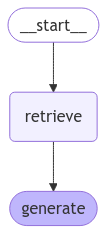

In [73]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [80]:
ask("Can you recommend me some books that you have about Sherlock", config)

Using book: The Hound of the Baskervilles in context
Using book: A Study in Scarlet in context
Using book: The Valley of Fear in context
Using book: The Sign of Four in context
Certainly! I can recommend some excellent Sherlock Holmes books we have here. Here are a few:

*   **The Hound of the Baskervilles** by Arthur Conan Doyle. In this thrilling mystery, Sherlock Holmes investigates a mysterious hound that haunts the Baskerville family, threatening their lives.

*   **A Study in Scarlet** by Arthur Conan Doyle. This is where it all began! It's Sherlock Holmes's very first case, involving a perplexing murder in London. It's a great introduction to the character and his methods.

*   **The Valley of Fear** by Arthur Conan Doyle. Holmes investigates a mysterious murder in a remote country house, uncovering a complex web of secrets and a dangerous conspiracy.

*   **The Sign of Four** by Arthur Conan Doyle. Holmes delves into a case involving a secret treasure, a mysterious one-legged m

In [81]:
ask("I do like the The Valley of Fear", config)

Using book: The Valley of Fear in context
Ah, a fan of classic mysteries! "The Valley of Fear" by Sir Arthur Conan Doyle is a thrilling Sherlock Holmes adventure. In it, Holmes and Watson are called to investigate a bizarre and seemingly impossible murder at a secluded country estate. The story unfolds with Holmes using his brilliant deductive skills to unravel a complex web of secrets and lies, ultimately revealing a hidden connection to a dark and dangerous past. It's a classic Holmes tale full of suspense and intrigue!



In [83]:
ask("Tell me more about the book valley of fear", config)

Using book: The Valley of Fear in context
Using book: The Haunting of Hill House in context
Using book: Pet Semetary in context
Using book: At the Mountains of Madness in context
Ah, "The Valley of Fear"! That's a classic Sherlock Holmes mystery written by Sir Arthur Conan Doyle. In this book, Holmes investigates a mysterious murder that takes place in a remote country house. It's a thrilling case filled with intrigue and deduction, just what you'd expect from a Sherlock Holmes story!

